## Import

In [25]:
from tqdm import tqdm
import glob, os
import matplotlib.pyplot as plt
import warnings
from pandas_profiling import ProfileReport
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import mutual_info_regression, SelectKBest

import lightgbm as lgb
from catboost import CatBoostRegressor

import numpy as np
import gc

import joblib
import scipy.stats as stats

%matplotlib inline

warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 150)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', 150)

import seaborn as sns
if os.name == 'nt' : # Windows OS
    font_family= "Malgun Gothic"
else: # MAC OS
    font_family= "AppleGothic"
# - 값이 깨지는 문제 해결을 위해 파라미터값 설정
sns.set(font = font_family, rc = {"axes.unicode_minus" : False})

In [26]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7748810921476704492
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4163895296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5829048536052406516
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


## csv to parquet

In [27]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [28]:
csv_to_parquet('train.csv', 'train')
csv_to_parquet('test.csv', 'test')
#csv_to_parquet('trainlgbm.csv', 'trainlgbm')

train Done.
test Done.


## 데이터 불러오기 및 간단한 EDA

In [29]:
# x->train_data EDA용
x = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
#trainlgbm = pd.read_parquet('trainlgbm.parquet')
y = x[['target']]

In [30]:
'''
trainlgbm.columns = ['predict_target']
x = pd.concat([x, trainlgbm], axis=1)
x['tar_pre_diff'] = x['target']-x['predict_target']
x['abs_tar_pre_diff'] = abs(x['target']-x['predict_target'])
'''

"\ntrainlgbm.columns = ['predict_target']\nx = pd.concat([x, trainlgbm], axis=1)\nx['tar_pre_diff'] = x['target']-x['predict_target']\nx['abs_tar_pre_diff'] = abs(x['target']-x['predict_target'])\n"

<AxesSubplot:xlabel='target'>

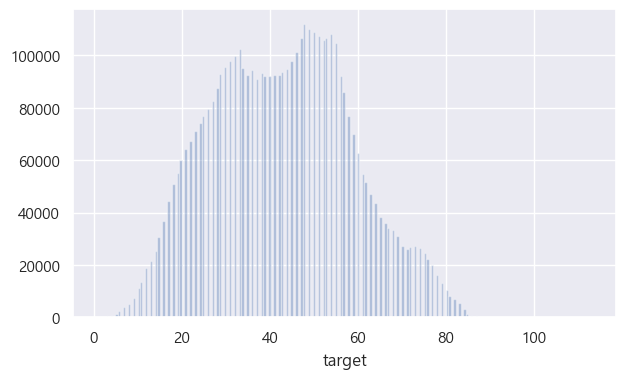

In [31]:
plt.figure(figsize=(7, 4))
sns.distplot(x['target'], bins=200, kde=False)

In [ ]:
# lgbm이 타겟으로 예측한 값들의 분포
plt.figure(figsize=(7, 4))
sns.distplot(x['predict_target'], bins=200, kde=False)

In [ ]:
# 모델이 예측한 값의 차이 분포
plt.figure(figsize=(7, 4))
sns.distplot(x['tar_pre_diff'], bins=200, kde=False)

In [ ]:
x[x['abs_tar_pre_diff']>=40]

In [ ]:
x[x['abs_tar_pre_diff']>=20]['end_node_name'].value_counts()

In [22]:
basetemp2 = x.groupby('day_of_week').mean()[['target']]
basetemp2

,target
day_of_week,
금,42.450328
목,42.768345
수,42.770372
월,42.761365
일,43.179300
토,42.894117
화,42.699198


In [23]:
basetemp = x.groupby('base_date').mean()[['target']]

In [24]:
basetemp = basetemp.reset_index()

In [25]:
basetemp['base_date'] = basetemp["base_date"].apply(str)
basetemp['base_date'] = pd.to_datetime(basetemp['base_date'])

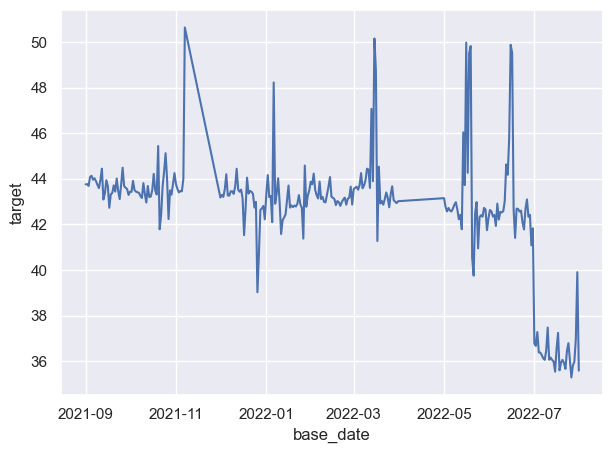

In [38]:
sns.set(rc = {'figure.figsize':(7,5)})
sns.lineplot(data=basetemp, x='base_date', y='target')
plt.show()

In [27]:
temp = x[x['base_date']==20211107]

In [28]:
temp[temp['target']>50]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
3465,TRAIN_0003465,20211107,일,0,1,103,일반국도16호선,0,0,60.0,0.0,32400.0,0.0,3,도순3교,33.258900,126.476922,없음,도순3교,33.258960,126.476508,없음,79.0
4086,TRAIN_0004086,20211107,일,1,3,106,지방도1132호선,0,0,70.0,0.0,0.0,0.0,0,강정교,33.250604,126.489259,없음,도순교,33.250441,126.479773,없음,56.0
9315,TRAIN_0009315,20211107,일,0,2,103,일반국도95호선,0,0,80.0,0.0,43200.0,0.0,3,경마장교,33.412945,126.396511,없음,경마장교,33.413158,126.396837,없음,74.0
14361,TRAIN_0014361,20211107,일,2,1,106,지방도97호선,0,0,60.0,0.0,0.0,0.0,0,제2성읍교,33.408913,126.772518,없음,성읍2리,33.410423,126.769650,없음,54.0
17444,TRAIN_0017444,20211107,일,0,2,107,-,0,0,80.0,0.0,0.0,0.0,0,양계장,33.475446,126.388193,없음,수간교차로,33.471164,126.395147,없음,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688514,TRAIN_4688514,20211107,일,0,1,103,일반국도11호선,0,0,60.0,0.0,0.0,0.0,0,윤고교,33.348305,126.614293,없음,수악교,33.337158,126.610343,없음,53.0
4689592,TRAIN_4689592,20211107,일,1,1,107,-,0,0,70.0,0.0,0.0,0.0,0,신하교,33.318075,126.618197,없음,송목교,33.317065,126.623867,없음,64.0
4689913,TRAIN_4689913,20211107,일,0,1,106,지방도1115호선,0,0,60.0,0.0,43200.0,0.0,3,제6산록교,33.291404,126.513613,없음,제6산록교,33.291359,126.514457,없음,56.0
4691502,TRAIN_4691502,20211107,일,2,2,103,일반국도12호선,0,0,50.0,0.0,0.0,0.0,0,오정카센타,33.452587,126.911865,없음,오조교차로,33.460952,126.910637,없음,52.0


<AxesSubplot:xlabel='base_date', ylabel='target'>

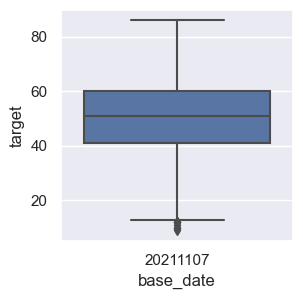

In [36]:
sns.set(rc = {'figure.figsize':(3,3)})
sns.boxplot(x="base_date",
            y="target",
            data=temp)

In [30]:
road = dict(x['road_name'].value_counts())

In [31]:
x.groupby('road_name').mean()[['target']]

,target
road_name,
-,44.774556
경찰로,24.686785
고평교,36.126862
관광단지1로,39.292453
관광단지2로,34.469287
관광단지로,30.307276
관덕로,30.295770
권학로,26.800154
남조로,34.098048


In [39]:
x['road_name'].nunique()

61

In [40]:
x['road_name'].unique()

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

In [41]:
for i in x['road_name'].unique():
    globals()["r{}".format(i)] = x[x['road_name']==i]

In [42]:
train_temp = x[['road_name', 'maximum_speed_limit']]
df_max_speed_per_nodename = train_temp.groupby("road_name").max()
df_max_speed_per_nodename.rename(columns = {'maximum_speed_limit' : 'maximum_speed_limit(max)'}, inplace = True)

df_min_speed_per_nodename = train_temp.groupby("road_name").min()
df_min_speed_per_nodename.rename(columns = {'maximum_speed_limit' : 'maximum_speed_limit(min)'}, inplace = True)

result = pd.concat([df_max_speed_per_nodename, df_min_speed_per_nodename['maximum_speed_limit(min)']], axis=1)
result

,maximum_speed_limit(max),maximum_speed_limit(min)
road_name,,
-,80.0,30.0
경찰로,60.0,60.0
고평교,50.0,50.0
관광단지1로,30.0,30.0
관광단지2로,30.0,30.0
관광단지로,30.0,30.0
관덕로,60.0,60.0
권학로,60.0,60.0
남조로,60.0,50.0


In [43]:
r연북로['maximum_speed_limit'].value_counts()

30.0    6049
50.0    6044
Name: maximum_speed_limit, dtype: int64

<AxesSubplot:xlabel='maximum_speed_limit', ylabel='Density'>

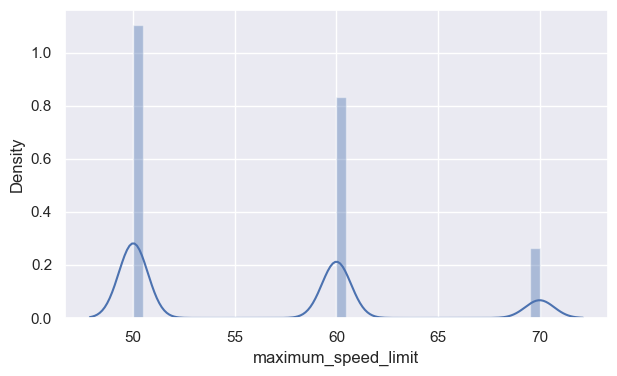

In [44]:
plt.figure(figsize=(7, 4))
sns.distplot(r지방도1118호선['maximum_speed_limit'])

In [45]:
print(r지방도1118호선[r지방도1118호선['maximum_speed_limit']==70]['target'].mean())
print(r지방도1118호선[r지방도1118호선['maximum_speed_limit']==60]['target'].mean())
print(r지방도1118호선[r지방도1118호선['maximum_speed_limit']==50]['target'].mean())

55.71353909870822
48.10905810625855
51.33253661394259


### 전처리

In [46]:
x2 = pd.concat([x, test], axis=0)

In [47]:
x2.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,0.0,32400.0,0.0,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0.0,0.0,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0.0,0.0,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,0.0,0.0,0.0,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0.0,0.0,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [48]:
x2.drop(['target', 'id'], axis=1, inplace=True)

In [49]:
x2.reset_index(inplace=True, drop=True)
x2.head()

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,20220623,목,17,1,106,지방도1112호선,0,0,60.0,0.0,32400.0,0.0,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음
1,20220728,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0.0,0.0,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음
2,20211010,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0.0,0.0,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음
3,20220311,금,13,2,107,태평로,0,0,50.0,0.0,0.0,0.0,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음
4,20211005,화,8,2,103,일반국도12호선,0,0,80.0,0.0,0.0,0.0,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음


In [50]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992458 entries, 0 to 4992457
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   base_date              int64  
 1   day_of_week            object 
 2   base_hour              int64  
 3   lane_count             int64  
 4   road_rating            int64  
 5   road_name              object 
 6   multi_linked           int64  
 7   connect_code           int64  
 8   maximum_speed_limit    float64
 9   vehicle_restricted     float64
 10  weight_restricted      float64
 11  height_restricted      float64
 12  road_type              int64  
 13  start_node_name        object 
 14  start_latitude         float64
 15  start_longitude        float64
 16  start_turn_restricted  object 
 17  end_node_name          object 
 18  end_latitude           float64
 19  end_longitude          float64
 20  end_turn_restricted    object 
dtypes: float64(8), int64(7), object(6)
memory usage: 799.9

In [51]:
#plt.figure(figsize=(7, 4))
#sns.distplot(y)

In [52]:
import datetime
def process_dt(train):
    train["base_date"] = train["base_date"].apply(str)
    
    df_tmp = pd.DataFrame(train.copy())
    df_tmp["datetime"] = [
        datetime.datetime.strptime(timestamp, "%Y%m%d") for timestamp in df_tmp["base_date"]
    ]
    df_tmp["date"] = df_tmp["datetime"].dt.date
    df_tmp["year"] = df_tmp["datetime"].dt.year
    df_tmp["quarter"] = df_tmp["datetime"].dt.quarter
    df_tmp["month"] = df_tmp["datetime"].dt.month
    df_tmp["day"] = df_tmp["datetime"].dt.day
    return df_tmp

'''
import datetime
def process_dt(train):
    #train["base_date"] = train["Time"].apply(str)
    train['base_date'] = pd.to_datetime(train['Time'], format='%Y-%m-%d %H:%M:%S')
    df_tmp = pd.DataFrame(train.copy())
    #df_tmp["date"] = df_tmp["base_date"].dt.date
    df_tmp["year"] = df_tmp["base_date"].dt.year
    df_tmp["quarter"] = df_tmp["base_date"].dt.quarter
    df_tmp["month"] = df_tmp["base_date"].dt.month
    df_tmp["day"] = df_tmp["base_date"].dt.day
    df_tmp["hour"] = df_tmp['base_date'].dt.hour
    df_tmp["minue"] = df_tmp['base_date'].dt.minute
    #df_tmp["second"] = df_tmp['base_date'].dt.second
    return df_tmp
'''

In [53]:
x2 = process_dt(x2)

In [54]:
x2.to_parquet('날짜변환.parquet')

In [32]:
#x2 = pd.read_parquet('날짜변환.parquet')

In [33]:
x2['la_diff'] = abs(x2['start_latitude']-x2['end_latitude'])
x2['lo_diff'] = abs(x2['start_longitude']-x2['end_longitude'])
x2['lalo_diff_sum'] = x2['la_diff']+x2['lo_diff']
x2['lalo_diff_mi'] = abs(x2['la_diff']-x2['lo_diff'])
#x2['lalo_diff_mul'] = round(x2['lo_diff']*x2['la_diff'], 8)
x2['la_div'] = x2['la_diff']/x2['lo_diff']
x2['lo_div'] = x2['lo_diff']/x2['la_diff']

x2['ifsame_st_ed'] = x2['start_node_name'] == x2['end_node_name']

In [34]:
x2.drop(['datetime', 'date', 'base_date'], inplace=True, axis=1)
x2.head(3)

,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,year,quarter,month,day,la_diff,lo_diff,lalo_diff_sum,lalo_diff_mi,la_div,lo_div,ifsame_st_ed
0,목,17,1,106,지방도1112호선,0,0,60.0,0.0,32400.0,0.0,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,2022,2,6,23,0.000001,0.000277,0.000279,0.000276,0.005408,184.901516,True
1,목,21,2,103,일반국도11호선,0,0,60.0,0.0,0.0,0.0,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,2022,3,7,28,0.004081,0.002867,0.006948,0.001214,1.423551,0.702469,False
2,일,7,2,103,일반국도16호선,0,0,80.0,0.0,0.0,0.0,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,2021,4,10,10,0.000927,0.006450,0.007377,0.005523,0.143718,6.958051,False


In [35]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992458 entries, 0 to 4992457
Data columns (total 31 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   day_of_week            object 
 1   base_hour              int64  
 2   lane_count             int64  
 3   road_rating            int64  
 4   road_name              object 
 5   multi_linked           int64  
 6   connect_code           int64  
 7   maximum_speed_limit    float64
 8   vehicle_restricted     float64
 9   weight_restricted      float64
 10  height_restricted      float64
 11  road_type              int64  
 12  start_node_name        object 
 13  start_latitude         float64
 14  start_longitude        float64
 15  start_turn_restricted  object 
 16  end_node_name          object 
 17  end_latitude           float64
 18  end_longitude          float64
 19  end_turn_restricted    object 
 20  year                   int64  
 21  quarter                int64  
 22  month             

In [8]:
'''
# 가입 없이 좌표->주소 변환
from geopy.geocoders import Nominatim

def geocoding_reverse(lat_lng_str): 
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    address = geolocoder.reverse(lat_lng_str)

    return address

address = geocoding_reverse('33.427747, 126.662612')
print(address)
'''

"\n# 가입 없이 좌표->주소 변환\nfrom geopy.geocoders import Nominatim\n\ndef geocoding_reverse(lat_lng_str): \n    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)\n    address = geolocoder.reverse(lat_lng_str)\n\n    return address\n\naddress = geocoding_reverse('33.427747, 126.662612')\nprint(address)\n"

### train 데이터와 test 데이터가 서로 공통의 변수가 얼마나 있는지 확인

In [22]:
d = []
def multi_intersection(x, test):
    for i in x.columns:
        name = i
        a = x[i].nunique()
        b = test[i].nunique()
        c = len(set(x[i]).intersection(set(test[i])))
        d.append(i)
        d.append(a)
        d.append(b)
        d.append(c)
        if b != c:
            d.append('데이터 이상')
        d.append('---------------------')
    return d

In [24]:
multi_intersection(x.drop('target', axis=1), test)

['id',
 4701217,
 291241,
 0,
 '데이터 이상',
 '---------------------',
 'base_date',
 281,
 31,
 0,
 '데이터 이상',
 '---------------------',
 'day_of_week',
 7,
 7,
 7,
 '---------------------',
 'base_hour',
 24,
 24,
 24,
 '---------------------',
 'lane_count',
 3,
 3,
 3,
 '---------------------',
 'road_rating',
 3,
 3,
 3,
 '---------------------',
 'road_name',
 61,
 46,
 46,
 '---------------------',
 'multi_linked',
 2,
 1,
 1,
 '---------------------',
 'connect_code',
 2,
 1,
 1,
 '---------------------',
 'maximum_speed_limit',
 6,
 5,
 5,
 '---------------------',
 'vehicle_restricted',
 1,
 1,
 1,
 '---------------------',
 'weight_restricted',
 4,
 4,
 4,
 '---------------------',
 'height_restricted',
 1,
 1,
 1,
 '---------------------',
 'road_type',
 2,
 2,
 2,
 '---------------------',
 'start_node_name',
 487,
 250,
 250,
 '---------------------',
 'start_latitude',
 586,
 294,
 294,
 '---------------------',
 'start_longitude',
 586,
 294,
 294,
 '---------------------',


### train 데이터에서 중복값 확인

In [ ]:
tempcc = x

In [ ]:
tempcc = tempcc.astype('str')
tempcc = tempcc[tempcc['end_node_name']=='성산교차로']
tempcc = tempcc[tempcc['day_of_week']=='수']
tempcc = tempcc[tempcc['base_hour']=='14']
tempcc = tempcc[tempcc['start_node_name']=='고성교차로']
tempcc = tempcc.sort_values(by=['start_node_name', 'base_date'])

In [ ]:
tempcc = tempcc.sort_values(by=['start_node_name', 'base_date'])

In [ ]:
tempcc.head()

### LGBM에 들어갈 변수 인코딩 or 카테고리 변수로 변환

In [36]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
class MultiColLabelEncoder:
    def __init__(self):
        self.encoder_dict = defaultdict(LabelEncoder)

    def fit_transform(self, X: pd.DataFrame, columns: list):
        if not isinstance(columns, list):
            columns = [columns]

        output = X.copy()
        output[columns] = X[columns].apply(lambda x: self.encoder_dict[x.name].fit_transform(x))

        return output

In [37]:
cat_feature = [col for col in x2 if x2[col].dtypes == "object"]
#cat_feature2 = [col for col in x2 if x2[col].dtypes == "int64"]
#cat_feature3 = [col for col in x2 if x2[col].dtypes == "category"]
cat_feature.append('ifsame_st_ed')

#for i in cat_feature2:
#    cat_feature.append(i)
#for i in cat_feature3:
#    cat_feature.append(i)
len(cat_feature)

7

In [38]:
mle = MultiColLabelEncoder()
x2 = mle.fit_transform(x2, columns = cat_feature)

In [39]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992458 entries, 0 to 4992457
Data columns (total 31 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   day_of_week            int32  
 1   base_hour              int64  
 2   lane_count             int64  
 3   road_rating            int64  
 4   road_name              int32  
 5   multi_linked           int64  
 6   connect_code           int64  
 7   maximum_speed_limit    float64
 8   vehicle_restricted     float64
 9   weight_restricted      float64
 10  height_restricted      float64
 11  road_type              int64  
 12  start_node_name        int32  
 13  start_latitude         float64
 14  start_longitude        float64
 15  start_turn_restricted  int32  
 16  end_node_name          int32  
 17  end_latitude           float64
 18  end_longitude          float64
 19  end_turn_restricted    int32  
 20  year                   int64  
 21  quarter                int64  
 22  month             

In [ ]:
#for i in cat_feature:
#    x2[i] = x2[i].astype('category')

## 모델 선언 및 학습 (간단한 lgbm)

In [88]:
x_encoding = x2.iloc[:50000, :]
y_encoding = y.iloc[:50000, :]
test2 = x2.iloc[4701217:, :]
x_final = x2.iloc[:4701217, :]

In [89]:
x_train, x_test, y_train, y_test = train_test_split(x_encoding, y_encoding, test_size=0.2, random_state=9)

In [90]:
#LR = lgb.LGBMRegressor(random_state=9, n_jobs=-1, categorical_feature=cat_feature)
LR = lgb.LGBMRegressor(random_state=9, n_jobs=-1)
LR.fit(x_train, y_train)

LGBMRegressor(random_state=9)

In [91]:
y_pred = LR.predict(x_test)
y_pred = pd.DataFrame(y_pred)

In [92]:
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('r2_score: {}'.format(r2_score(y_test, y_pred)))

MAE: 4.504323172876089
r2_score: 0.8570957333981808


Text(0.5, 1.0, 'Feature Importance')

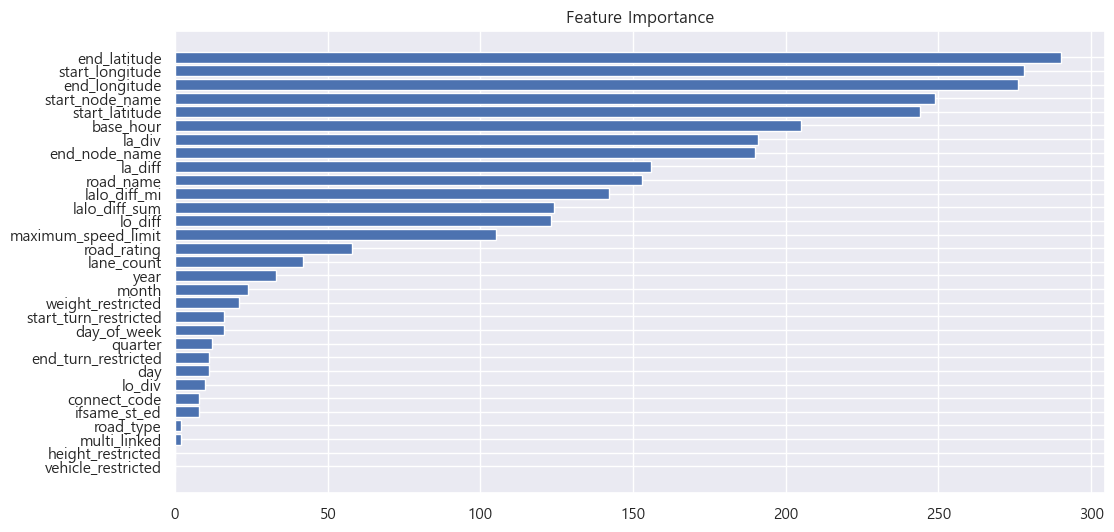

In [93]:
feature_importance = LR.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')

### CatBoost

In [62]:
catcl = CatBoostRegressor(verbose = 100)
catcl.fit(x_train, y_train)

Learning rate set to 0.073334
0:	learn: 15.3378018	total: 161ms	remaining: 2m 40s
100:	learn: 7.5808568	total: 627ms	remaining: 5.58s
200:	learn: 6.6850678	total: 1.09s	remaining: 4.34s
300:	learn: 6.2512608	total: 1.51s	remaining: 3.52s
400:	learn: 5.9686595	total: 1.96s	remaining: 2.93s
500:	learn: 5.7652134	total: 2.4s	remaining: 2.39s
600:	learn: 5.6094207	total: 2.83s	remaining: 1.88s
700:	learn: 5.4706784	total: 3.26s	remaining: 1.39s
800:	learn: 5.3605498	total: 3.68s	remaining: 914ms
900:	learn: 5.2635823	total: 4.1s	remaining: 450ms
999:	learn: 5.1769122	total: 4.52s	remaining: 0us


In [63]:
y_pred = catcl.predict(x_test)
y_pred = pd.DataFrame(y_pred)

print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
print('r2_score: {}'.format(r2_score(y_test, y_pred)))

MAE: 4.0929013697185725
r2_score: 0.8828906918579396


In [94]:
from sklearn.model_selection import train_test_split, KFold
scores = []

models = []
cv = KFold(n_splits=5, shuffle=True, random_state=9)
for tri, vai in cv.split(x_train):
    print("="*50)
    preds = []

    model = CatBoostRegressor(iterations=20000,random_state=9, eval_metric="MAPE")#, task_type="GPU", cat_features=cat_feature) 
    model.fit(x_train.iloc[tri], y_train.iloc[tri], 
            eval_set=[(x_train.iloc[vai], y_train.iloc[vai])], 
            early_stopping_rounds=100,
            verbose = 200
        )
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["MAPE"])
    if False:
        break

Learning rate set to 0.014112
0:	learn: 0.4212804	test: 0.4235431	best: 0.4235431 (0)	total: 6.21ms	remaining: 2m 4s
200:	learn: 0.2271018	test: 0.2275662	best: 0.2275662 (200)	total: 813ms	remaining: 1m 20s
400:	learn: 0.1997219	test: 0.1999185	best: 0.1999185 (400)	total: 1.62s	remaining: 1m 19s
600:	learn: 0.1845460	test: 0.1850549	best: 0.1850549 (600)	total: 2.47s	remaining: 1m 19s
800:	learn: 0.1735940	test: 0.1743695	best: 0.1743695 (800)	total: 3.29s	remaining: 1m 18s
1000:	learn: 0.1654989	test: 0.1666615	best: 0.1666615 (1000)	total: 4.09s	remaining: 1m 17s
1200:	learn: 0.1592169	test: 0.1608433	best: 0.1608433 (1200)	total: 4.89s	remaining: 1m 16s
1400:	learn: 0.1543529	test: 0.1563279	best: 0.1563279 (1400)	total: 5.73s	remaining: 1m 16s
1600:	learn: 0.1502917	test: 0.1527127	best: 0.1527127 (1600)	total: 6.54s	remaining: 1m 15s
1800:	learn: 0.1466897	test: 0.1495406	best: 0.1495406 (1800)	total: 7.35s	remaining: 1m 14s
2000:	learn: 0.1437721	test: 0.1470974	best: 0.1470974

17600:	learn: 0.0895377	test: 0.1182454	best: 0.1182451 (17576)	total: 1m 15s	remaining: 10.3s
17800:	learn: 0.0892265	test: 0.1182024	best: 0.1182016 (17798)	total: 1m 16s	remaining: 9.48s
18000:	learn: 0.0889183	test: 0.1181612	best: 0.1181571 (17990)	total: 1m 17s	remaining: 8.63s
18200:	learn: 0.0886112	test: 0.1181420	best: 0.1181399 (18141)	total: 1m 18s	remaining: 7.77s
18400:	learn: 0.0883106	test: 0.1181019	best: 0.1181018 (18398)	total: 1m 19s	remaining: 6.91s
18600:	learn: 0.0880191	test: 0.1180516	best: 0.1180516 (18600)	total: 1m 20s	remaining: 6.04s
18800:	learn: 0.0877239	test: 0.1180103	best: 0.1180092 (18789)	total: 1m 21s	remaining: 5.18s
19000:	learn: 0.0874275	test: 0.1179603	best: 0.1179596 (18998)	total: 1m 22s	remaining: 4.32s
19200:	learn: 0.0871412	test: 0.1179239	best: 0.1179239 (19200)	total: 1m 23s	remaining: 3.46s
19400:	learn: 0.0868555	test: 0.1178988	best: 0.1178988 (19400)	total: 1m 23s	remaining: 2.59s
19600:	learn: 0.0865678	test: 0.1178517	best: 0.11

14800:	learn: 0.0945158	test: 0.1184444	best: 0.1184442 (14796)	total: 1m 12s	remaining: 25.5s
15000:	learn: 0.0941658	test: 0.1183678	best: 0.1183665 (14998)	total: 1m 13s	remaining: 24.5s
15200:	learn: 0.0938038	test: 0.1182923	best: 0.1182923 (15200)	total: 1m 14s	remaining: 23.6s
15400:	learn: 0.0934482	test: 0.1182312	best: 0.1182306 (15399)	total: 1m 15s	remaining: 22.7s
15600:	learn: 0.0930983	test: 0.1181836	best: 0.1181825 (15598)	total: 1m 16s	remaining: 21.7s
15800:	learn: 0.0927609	test: 0.1181286	best: 0.1181280 (15793)	total: 1m 17s	remaining: 20.7s
16000:	learn: 0.0924119	test: 0.1180409	best: 0.1180392 (15992)	total: 1m 18s	remaining: 19.7s
16200:	learn: 0.0921047	test: 0.1179996	best: 0.1179993 (16199)	total: 1m 19s	remaining: 18.7s
16400:	learn: 0.0917858	test: 0.1179588	best: 0.1179588 (16400)	total: 1m 20s	remaining: 17.7s
16600:	learn: 0.0914661	test: 0.1179087	best: 0.1179087 (16600)	total: 1m 21s	remaining: 16.8s
16800:	learn: 0.0911458	test: 0.1178596	best: 0.11

12000:	learn: 0.1000309	test: 0.1215302	best: 0.1215298 (11998)	total: 55s	remaining: 36.6s
12200:	learn: 0.0996105	test: 0.1214505	best: 0.1214505 (12200)	total: 55.8s	remaining: 35.7s
12400:	learn: 0.0991966	test: 0.1213747	best: 0.1213725 (12395)	total: 56.7s	remaining: 34.7s
12600:	learn: 0.0987986	test: 0.1212871	best: 0.1212871 (12600)	total: 57.7s	remaining: 33.9s
12800:	learn: 0.0984048	test: 0.1212072	best: 0.1212072 (12800)	total: 58.6s	remaining: 33s
13000:	learn: 0.0979978	test: 0.1210995	best: 0.1210995 (13000)	total: 59.5s	remaining: 32s
13200:	learn: 0.0976092	test: 0.1210010	best: 0.1209999 (13196)	total: 1m	remaining: 31.1s
13400:	learn: 0.0972314	test: 0.1209345	best: 0.1209345 (13400)	total: 1m 1s	remaining: 30.2s
13600:	learn: 0.0968343	test: 0.1208274	best: 0.1208274 (13600)	total: 1m 2s	remaining: 29.3s
13800:	learn: 0.0964431	test: 0.1207336	best: 0.1207336 (13799)	total: 1m 3s	remaining: 28.4s
14000:	learn: 0.0960691	test: 0.1206628	best: 0.1206618 (13999)	total

9200:	learn: 0.1059070	test: 0.1254773	best: 0.1254773 (9200)	total: 41.4s	remaining: 48.5s
9400:	learn: 0.1053893	test: 0.1252693	best: 0.1252684 (9399)	total: 42.3s	remaining: 47.7s
9600:	learn: 0.1048493	test: 0.1250444	best: 0.1250444 (9600)	total: 43.2s	remaining: 46.8s
9800:	learn: 0.1043267	test: 0.1248424	best: 0.1248424 (9800)	total: 44.1s	remaining: 45.9s
10000:	learn: 0.1038459	test: 0.1246730	best: 0.1246730 (10000)	total: 45s	remaining: 44.9s
10200:	learn: 0.1033349	test: 0.1244756	best: 0.1244738 (10196)	total: 45.8s	remaining: 44s
10400:	learn: 0.1028472	test: 0.1242978	best: 0.1242978 (10400)	total: 46.7s	remaining: 43.1s
10600:	learn: 0.1023708	test: 0.1241441	best: 0.1241441 (10600)	total: 47.6s	remaining: 42.2s
10800:	learn: 0.1019251	test: 0.1240174	best: 0.1240174 (10800)	total: 48.6s	remaining: 41.4s
11000:	learn: 0.1014627	test: 0.1238938	best: 0.1238938 (11000)	total: 49.4s	remaining: 40.4s
11200:	learn: 0.1010266	test: 0.1237551	best: 0.1237551 (11200)	total: 5

6400:	learn: 0.1143138	test: 0.1276916	best: 0.1276916 (6400)	total: 29s	remaining: 1m 1s
6600:	learn: 0.1135668	test: 0.1273228	best: 0.1273228 (6600)	total: 29.8s	remaining: 1m
6800:	learn: 0.1128514	test: 0.1269765	best: 0.1269765 (6800)	total: 30.7s	remaining: 59.6s
7000:	learn: 0.1121689	test: 0.1266693	best: 0.1266693 (7000)	total: 31.6s	remaining: 58.7s
7200:	learn: 0.1115107	test: 0.1263627	best: 0.1263627 (7200)	total: 32.5s	remaining: 57.7s
7400:	learn: 0.1108502	test: 0.1260342	best: 0.1260342 (7400)	total: 33.4s	remaining: 56.8s
7600:	learn: 0.1102334	test: 0.1257691	best: 0.1257691 (7600)	total: 34.3s	remaining: 55.9s
7800:	learn: 0.1095960	test: 0.1255037	best: 0.1255037 (7800)	total: 35.3s	remaining: 55.2s
8000:	learn: 0.1089997	test: 0.1252269	best: 0.1252269 (8000)	total: 36.3s	remaining: 54.4s
8200:	learn: 0.1084308	test: 0.1249953	best: 0.1249953 (8200)	total: 37.2s	remaining: 53.5s
8400:	learn: 0.1078646	test: 0.1247661	best: 0.1247661 (8400)	total: 38.1s	remaining:

In [95]:
cat_pred = model.predict(x_test)

mean_absolute_error(y_test, cat_pred)

3.815968675136543

Text(0.5, 1.0, 'Feature Importance')

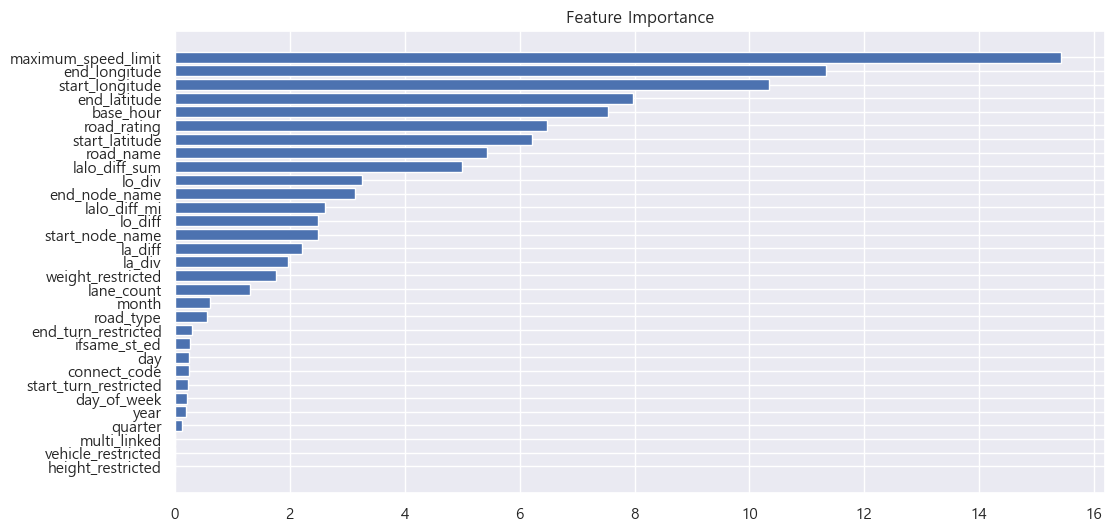

In [96]:
feature_importance = catcl.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')

In [97]:
from ngboost import NGBRegressor

In [98]:
ngb = NGBRegressor()

In [99]:
ngb.fit(x_train, y_train)

[iter 0] loss=4.1914 val_loss=0.0000 scale=1.0000 norm=13.2761
[iter 100] loss=3.8923 val_loss=0.0000 scale=2.0000 norm=19.2889
[iter 200] loss=3.7250 val_loss=0.0000 scale=1.0000 norm=8.1677
[iter 300] loss=3.6289 val_loss=0.0000 scale=1.0000 norm=7.5250
[iter 400] loss=3.5721 val_loss=0.0000 scale=1.0000 norm=7.1769


NGBRegressor(random_state=RandomState(MT19937) at 0x2460353F9D8)

In [101]:
ngb_pred = ngb.predict(x_test)

mean_absolute_error(y_test, ngb_pred)

6.8715242641953695

### xgb

In [103]:
import xgboost as xgb
xgbR=xgb.XGBRegressor( n_jobs=-1)#, tree_method="gpu_hist")

In [104]:
xgbR.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [105]:
xgbR_pred = xgbR.predict(x_train)

mean_absolute_error(y_train, xgbR_pred)

3.447983474123478

In [109]:
import xgboost as xgb
import optuna

def objective(trial):
    
    train_x, test_x, train_y, test_y = train_test_split(x_encoding, y_encoding, test_size=0.2, random_state=9)
    param = {
        'eval_metric': 'rmse',
        #'tree_method':'gpu_hist',
        #'predictor':'gpu_predictor',
        #'enable_categorical': 'True',
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
        'n_estimators': 500,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.3, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),     
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 128),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        # 'num_parallel_tree': trial.suggest_int("num_parallel_tree", 1, 500) 추가하면 느려짐.
        'n_jobs': '-1'
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=120,verbose=100)
    
    preds = model.predict(test_x)
    # squared=False면 rmse 반환
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [110]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-11-21 16:41:43,219] A new study created in memory with name: no-name-8ceddb24-c3d9-4d73-8994-d9a49162d705


[0]	validation_0-rmse:19.37455
[100]	validation_0-rmse:6.02785
[200]	validation_0-rmse:5.80499
[300]	validation_0-rmse:5.76744
[400]	validation_0-rmse:5.74937
[499]	validation_0-rmse:5.72778


[I 2022-11-21 16:41:46,148] Trial 0 finished with value: 5.72777968732942 and parameters: {'max_depth': 4, 'learning_rate': 0.6443618768676314, 'colsample_bytree': 0.8547033171971303, 'colsample_bylevel': 0.597313946005657, 'colsample_bynode': 0.4599656103964078, 'reg_lambda': 0.15356267583742284, 'reg_alpha': 0.2031653246285643, 'subsample': 0.6, 'min_child_weight': 44, 'gamma': 0.1779416726170944}. Best is trial 0 with value: 5.72777968732942.


[0]	validation_0-rmse:38.05084
[100]	validation_0-rmse:6.38692
[200]	validation_0-rmse:5.98623
[300]	validation_0-rmse:5.84790
[400]	validation_0-rmse:5.71018
[499]	validation_0-rmse:5.64205


[I 2022-11-21 16:41:49,314] Trial 1 finished with value: 5.642048644528307 and parameters: {'max_depth': 28, 'learning_rate': 0.1833243530646681, 'colsample_bytree': 0.4383554269849113, 'colsample_bylevel': 0.36544789623157936, 'colsample_bynode': 0.41625987189904057, 'reg_lambda': 0.02056332713768481, 'reg_alpha': 0.19827990722110467, 'subsample': 0.85, 'min_child_weight': 66, 'gamma': 0.15304289739607838}. Best is trial 1 with value: 5.642048644528307.


[0]	validation_0-rmse:24.33259
[100]	validation_0-rmse:5.70025
[155]	validation_0-rmse:5.79524


[I 2022-11-21 16:41:52,925] Trial 2 finished with value: 5.517662776266832 and parameters: {'max_depth': 24, 'learning_rate': 0.4873762638629911, 'colsample_bytree': 0.6732739234003494, 'colsample_bylevel': 0.9170480008046504, 'colsample_bynode': 0.7881233219762642, 'reg_lambda': 0.9212156074791437, 'reg_alpha': 0.13614666605879577, 'subsample': 0.8, 'min_child_weight': 91, 'gamma': 0.5084156075028892}. Best is trial 2 with value: 5.517662776266832.


[0]	validation_0-rmse:44.98874
[100]	validation_0-rmse:18.50005
[200]	validation_0-rmse:9.49288
[300]	validation_0-rmse:6.97814
[400]	validation_0-rmse:6.28177
[499]	validation_0-rmse:6.02451


[I 2022-11-21 16:41:59,941] Trial 3 finished with value: 6.024510298926118 and parameters: {'max_depth': 22, 'learning_rate': 0.009839260653344199, 'colsample_bytree': 0.7687989510719591, 'colsample_bylevel': 0.4309032977229297, 'colsample_bynode': 0.37298156067791755, 'reg_lambda': 0.6308912515492222, 'reg_alpha': 0.13750475578120952, 'subsample': 0.8, 'min_child_weight': 111, 'gamma': 0.10673668568638499}. Best is trial 2 with value: 5.517662776266832.


[0]	validation_0-rmse:12.40954
[100]	validation_0-rmse:6.31195
[130]	validation_0-rmse:6.39358


[I 2022-11-21 16:42:02,981] Trial 4 finished with value: 5.785785364889174 and parameters: {'max_depth': 18, 'learning_rate': 0.7785432987270283, 'colsample_bytree': 0.5423927840293619, 'colsample_bylevel': 0.5651146756568146, 'colsample_bynode': 0.9533707093188191, 'reg_lambda': 0.6499492296944491, 'reg_alpha': 0.09642183274573915, 'subsample': 0.85, 'min_child_weight': 41, 'gamma': 0.1680247980985922}. Best is trial 2 with value: 5.517662776266832.


[0]	validation_0-rmse:19.41019
[100]	validation_0-rmse:6.12268
[129]	validation_0-rmse:6.21899


[I 2022-11-21 16:42:04,923] Trial 5 finished with value: 5.6923585557903245 and parameters: {'max_depth': 11, 'learning_rate': 0.6144030328435971, 'colsample_bytree': 0.9588133484563155, 'colsample_bylevel': 0.4461814340746487, 'colsample_bynode': 0.4859736522798703, 'reg_lambda': 0.29584775990314527, 'reg_alpha': 0.011232956633471852, 'subsample': 0.8, 'min_child_weight': 5, 'gamma': 0.846126400390852}. Best is trial 2 with value: 5.517662776266832.


[0]	validation_0-rmse:39.79768
[100]	validation_0-rmse:5.55146
[200]	validation_0-rmse:5.40514
[300]	validation_0-rmse:5.36679
[400]	validation_0-rmse:5.35420
[499]	validation_0-rmse:5.35318


[I 2022-11-21 16:42:12,580] Trial 6 finished with value: 5.3502313021948344 and parameters: {'max_depth': 16, 'learning_rate': 0.1301254839025431, 'colsample_bytree': 0.6154343035414626, 'colsample_bylevel': 0.7641496770780035, 'colsample_bynode': 0.3303859102939399, 'reg_lambda': 0.10332478691203723, 'reg_alpha': 0.09223635930309049, 'subsample': 0.65, 'min_child_weight': 105, 'gamma': 0.672966311188589}. Best is trial 6 with value: 5.3502313021948344.


[0]	validation_0-rmse:24.97255
[100]	validation_0-rmse:5.54950
[165]	validation_0-rmse:5.62434


[I 2022-11-21 16:42:14,721] Trial 7 finished with value: 5.472214534176608 and parameters: {'max_depth': 12, 'learning_rate': 0.4740460646091679, 'colsample_bytree': 0.5939142451036223, 'colsample_bylevel': 0.47829537065030714, 'colsample_bynode': 0.5493446278736551, 'reg_lambda': 0.048450887929633285, 'reg_alpha': 0.5410527188744331, 'subsample': 0.9, 'min_child_weight': 42, 'gamma': 0.4779415431628278}. Best is trial 6 with value: 5.3502313021948344.


[0]	validation_0-rmse:29.21577
[100]	validation_0-rmse:5.46978
[168]	validation_0-rmse:5.53842


[I 2022-11-21 16:42:17,859] Trial 8 finished with value: 5.43045751026563 and parameters: {'max_depth': 25, 'learning_rate': 0.3716720817003068, 'colsample_bytree': 0.6659453321631967, 'colsample_bylevel': 0.3144553465730754, 'colsample_bynode': 0.7428257626548365, 'reg_lambda': 0.03565583126721831, 'reg_alpha': 0.05480565402963139, 'subsample': 0.95, 'min_child_weight': 84, 'gamma': 0.4968726961568082}. Best is trial 6 with value: 5.3502313021948344.


[0]	validation_0-rmse:20.29460
[100]	validation_0-rmse:5.80663
[152]	validation_0-rmse:5.90593


[I 2022-11-21 16:42:21,498] Trial 9 finished with value: 5.681258553673166 and parameters: {'max_depth': 21, 'learning_rate': 0.5838813283179781, 'colsample_bytree': 0.6689469217596921, 'colsample_bylevel': 0.9660405344645517, 'colsample_bynode': 0.9760094111436268, 'reg_lambda': 0.01535220404530663, 'reg_alpha': 0.11389043896833806, 'subsample': 0.7, 'min_child_weight': 122, 'gamma': 0.3825741822322438}. Best is trial 6 with value: 5.3502313021948344.


[0]	validation_0-rmse:36.99898
[100]	validation_0-rmse:8.98520
[200]	validation_0-rmse:8.16929
[300]	validation_0-rmse:7.76868
[400]	validation_0-rmse:7.51091
[499]	validation_0-rmse:7.32628


[I 2022-11-21 16:42:23,912] Trial 10 finished with value: 7.326280646423267 and parameters: {'max_depth': 2, 'learning_rate': 0.2108375373953688, 'colsample_bytree': 0.3151231157859163, 'colsample_bylevel': 0.8066616491082705, 'colsample_bynode': 0.3155930863634944, 'reg_lambda': 0.11207631823337039, 'reg_alpha': 0.025385573142317132, 'subsample': 0.6, 'min_child_weight': 96, 'gamma': 0.9787101973472362}. Best is trial 6 with value: 5.3502313021948344.


[0]	validation_0-rmse:32.06388
[100]	validation_0-rmse:5.39953
[165]	validation_0-rmse:5.46093


[I 2022-11-21 16:42:27,683] Trial 11 finished with value: 5.323365956962113 and parameters: {'max_depth': 30, 'learning_rate': 0.3041172858070025, 'colsample_bytree': 0.50914697478058, 'colsample_bylevel': 0.7514115708695837, 'colsample_bynode': 0.7016494832249646, 'reg_lambda': 0.043772884349013344, 'reg_alpha': 0.041004017756752775, 'subsample': 1.0, 'min_child_weight': 78, 'gamma': 0.6658935565215419}. Best is trial 11 with value: 5.323365956962113.


[0]	validation_0-rmse:45.21922
[100]	validation_0-rmse:29.56487
[200]	validation_0-rmse:19.67437
[300]	validation_0-rmse:13.54426
[400]	validation_0-rmse:9.88446
[499]	validation_0-rmse:7.80836


[I 2022-11-21 16:42:35,700] Trial 12 finished with value: 7.808355729576687 and parameters: {'max_depth': 30, 'learning_rate': 0.004436987293495731, 'colsample_bytree': 0.47629920869704734, 'colsample_bylevel': 0.7484903860032408, 'colsample_bynode': 0.645787574913234, 'reg_lambda': 0.05690801710114662, 'reg_alpha': 0.03346744202926111, 'subsample': 1.0, 'min_child_weight': 69, 'gamma': 0.6407781029649174}. Best is trial 11 with value: 5.323365956962113.


[0]	validation_0-rmse:34.53473
[100]	validation_0-rmse:5.48692
[200]	validation_0-rmse:5.41953
[300]	validation_0-rmse:5.42957
[350]	validation_0-rmse:5.44215


[I 2022-11-21 16:42:40,432] Trial 13 finished with value: 5.415694554293229 and parameters: {'max_depth': 14, 'learning_rate': 0.25188466473640087, 'colsample_bytree': 0.3765173717937237, 'colsample_bylevel': 0.7210808197498131, 'colsample_bynode': 0.617783779612103, 'reg_lambda': 0.20016783812211766, 'reg_alpha': 0.47767590586244435, 'subsample': 0.7, 'min_child_weight': 105, 'gamma': 0.27505569165706767}. Best is trial 11 with value: 5.323365956962113.


[0]	validation_0-rmse:30.78987
[100]	validation_0-rmse:5.57131
[200]	validation_0-rmse:5.48027
[300]	validation_0-rmse:5.46537
[400]	validation_0-rmse:5.47324
[467]	validation_0-rmse:5.47982


[I 2022-11-21 16:42:45,063] Trial 14 finished with value: 5.455556948032832 and parameters: {'max_depth': 8, 'learning_rate': 0.3381365393205502, 'colsample_bytree': 0.5085359215308983, 'colsample_bylevel': 0.852866764297466, 'colsample_bynode': 0.8073572175078347, 'reg_lambda': 0.0657268021928819, 'reg_alpha': 0.04832181764282991, 'subsample': 0.7, 'min_child_weight': 123, 'gamma': 0.6854144629665683}. Best is trial 11 with value: 5.323365956962113.


[0]	validation_0-rmse:40.80578
[100]	validation_0-rmse:5.28767
[200]	validation_0-rmse:5.24302
[300]	validation_0-rmse:5.25389
[333]	validation_0-rmse:5.26680


[I 2022-11-21 16:42:50,934] Trial 15 finished with value: 5.240079931757308 and parameters: {'max_depth': 18, 'learning_rate': 0.10458164576834184, 'colsample_bytree': 0.7795656535986142, 'colsample_bylevel': 0.67431422304976, 'colsample_bynode': 0.7086506913177681, 'reg_lambda': 0.027151996556925864, 'reg_alpha': 0.01803581477389336, 'subsample': 1.0, 'min_child_weight': 79, 'gamma': 0.2922804050903445}. Best is trial 15 with value: 5.240079931757308.


[0]	validation_0-rmse:8.36163
[100]	validation_0-rmse:6.33039
[132]	validation_0-rmse:6.41288


[I 2022-11-21 16:42:53,883] Trial 16 finished with value: 5.925882112130938 and parameters: {'max_depth': 19, 'learning_rate': 0.900514940916308, 'colsample_bytree': 0.7616462896915343, 'colsample_bylevel': 0.6601589217870198, 'colsample_bynode': 0.8666331401990258, 'reg_lambda': 0.010540996120121288, 'reg_alpha': 0.014297165821230048, 'subsample': 1.0, 'min_child_weight': 77, 'gamma': 0.2695024837782803}. Best is trial 15 with value: 5.240079931757308.


[0]	validation_0-rmse:29.51595
[100]	validation_0-rmse:5.59398
[146]	validation_0-rmse:5.66086


[I 2022-11-21 16:42:58,052] Trial 17 finished with value: 5.401330452978368 and parameters: {'max_depth': 27, 'learning_rate': 0.361111364217844, 'colsample_bytree': 0.8939087440631641, 'colsample_bylevel': 0.6625897471566108, 'colsample_bynode': 0.7177565329961828, 'reg_lambda': 0.02951714495702335, 'reg_alpha': 0.018066869959208746, 'subsample': 0.95, 'min_child_weight': 56, 'gamma': 0.35745378140395645}. Best is trial 15 with value: 5.240079931757308.


[0]	validation_0-rmse:43.11961
[100]	validation_0-rmse:5.74708
[200]	validation_0-rmse:5.44069
[300]	validation_0-rmse:5.32635
[400]	validation_0-rmse:5.26456
[499]	validation_0-rmse:5.23140


[I 2022-11-21 16:43:03,142] Trial 18 finished with value: 5.231399017814562 and parameters: {'max_depth': 8, 'learning_rate': 0.05247391376697802, 'colsample_bytree': 0.8004506306159268, 'colsample_bylevel': 0.5548682982823542, 'colsample_bynode': 0.5750684953445468, 'reg_lambda': 0.023699970275604772, 'reg_alpha': 0.026365042517537025, 'subsample': 0.95, 'min_child_weight': 5, 'gamma': 0.22733670754104243}. Best is trial 18 with value: 5.231399017814562.


[0]	validation_0-rmse:41.26188
[100]	validation_0-rmse:5.79207
[200]	validation_0-rmse:5.46792
[300]	validation_0-rmse:5.35429
[400]	validation_0-rmse:5.29153
[499]	validation_0-rmse:5.27409


[I 2022-11-21 16:43:07,538] Trial 19 finished with value: 5.273337754599907 and parameters: {'max_depth': 7, 'learning_rate': 0.09641659985578016, 'colsample_bytree': 0.766583914838648, 'colsample_bylevel': 0.5324816474009655, 'colsample_bynode': 0.5611723068624547, 'reg_lambda': 0.02061975242659782, 'reg_alpha': 0.025351601707340674, 'subsample': 0.9, 'min_child_weight': 4, 'gamma': 0.23136110340539662}. Best is trial 18 with value: 5.231399017814562.


Number of finished trials: 20
Best trial: {'max_depth': 8, 'learning_rate': 0.05247391376697802, 'colsample_bytree': 0.8004506306159268, 'colsample_bylevel': 0.5548682982823542, 'colsample_bynode': 0.5750684953445468, 'reg_lambda': 0.023699970275604772, 'reg_alpha': 0.026365042517537025, 'subsample': 0.95, 'min_child_weight': 5, 'gamma': 0.22733670754104243}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
study.best_params

In [ ]:
xgbR = xgb.XGBRegressor(**study.best_trial.params, n_estimators=2500)

In [ ]:
xgbR.fit(x_train, y_train, eval_set=[(x_test ,y_test)], early_stopping_rounds=220, eval_metric='mae')

In [ ]:
xgb_pred = xgbR.predict(x_encoding)


print('MAE: {}'.format(mean_absolute_error(y_encoding, xgb_pred)))
print('r2_score: {}'.format(r2_score(y_encoding, xgb_pred)))

In [ ]:
xgb_tune_submit_pred = xgbR.predict(test2)

In [ ]:
#y_pred2 = rftest
y_pred2 = xgb_tune_submit_pred
y_pred2 = pd.DataFrame(y_pred2)
y_pred2.columns = ['target']
sample_submission = pd.read_csv('/content/drive/MyDrive/MYJ/open/sample_submission.csv')
sample_submission.drop('target', axis=1, inplace=True)
sub = pd.concat([sample_submission, y_pred2], axis=1)

In [ ]:
print(sub.isnull().sum())
print(sub.head())

In [ ]:
sub.to_csv("xgb.csv", index = False)

### LGBM

In [125]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

random_state=9
np.random.seed(9)

def objective(trial):

    train_x, test_x, train_y, test_y = train_test_split(x_encoding, y_encoding, random_state=random_state, test_size=0.2)
    dtrain = lgb.Dataset(train_x, label=train_y)
    dval = lgb.Dataset(test_x, label=test_y)
    params = {
        'objective': 'regression',
        'metric': 'RMSE',
        'force_row_wise': True,
        'random_state': random_state,
        'early_stopping_round': 60,
        #'categorical_feature' : cat_feature,
        #'tree_learner': 'voting',
        'tree_learner': trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting']),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 32, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.3, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 32),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 128),
        'min_gain_to_split' : trial.suggest_discrete_uniform('min_gain_to_split', 0.1, 5, 0.01),
        'max_depth': trial.suggest_int('max_depth',2, 64),
        'max_bin': trial.suggest_int('max_bin', 32, 255),      
        #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 256),
        'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
        #'device': 'gpu',
        #'gpu_device_id': 0,
        'verbose': -1
        
    }
 
    gbm = lgb.train(params, dtrain, 3500, dval, verbose_eval=1000)
    preds = gbm.predict(test_x)
    rmse = mean_squared_error(test_y, preds, squared=False)
    
    return rmse

In [126]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print('Best Value:', study.best_value)
print('Best trial:', study.best_trial.params)

[I 2022-11-21 16:57:12,796] A new study created in memory with name: no-name-d9fe8e3a-0253-4bbe-90b3-e10a629528c4


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[600]	valid_0's rmse: 5.40428


[I 2022-11-21 16:57:16,128] Trial 0 finished with value: 5.404277392257727 and parameters: {'tree_learner': 'serial', 'learning_rate': 0.0459196116173005, 'lambda_l1': 1.4123534940795678e-08, 'lambda_l2': 0.00042183451821010964, 'num_leaves': 253, 'feature_fraction': 0.7265005431895152, 'bagging_fraction': 0.3877810623649288, 'bagging_freq': 15, 'min_child_samples': 72, 'min_gain_to_split': 1.1300000000000001, 'max_depth': 52, 'max_bin': 247, 'min_data_in_bin': 242}. Best is trial 0 with value: 5.404277392257727.


Training until validation scores don't improve for 60 rounds
[1000]	valid_0's rmse: 5.56906
Early stopping, best iteration is:
[1925]	valid_0's rmse: 5.51927


[I 2022-11-21 16:57:24,502] Trial 1 finished with value: 5.519366496953844 and parameters: {'tree_learner': 'serial', 'learning_rate': 0.01112338505490904, 'lambda_l1': 1.5486735010923864e-07, 'lambda_l2': 0.0003937890273101513, 'num_leaves': 467, 'feature_fraction': 0.41110835337151236, 'bagging_fraction': 0.9729676944933421, 'bagging_freq': 2, 'min_child_samples': 80, 'min_gain_to_split': 4.21, 'max_depth': 11, 'max_bin': 41, 'min_data_in_bin': 173}. Best is trial 0 with value: 5.404277392257727.


Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:57:26,585] Trial 2 finished with value: 5.41506460360334 and parameters: {'tree_learner': 'serial', 'learning_rate': 0.05750544972745388, 'lambda_l1': 2.2195303971552342e-07, 'lambda_l2': 0.0018033851241884974, 'num_leaves': 97, 'feature_fraction': 0.6270257746760326, 'bagging_fraction': 0.6599080349112596, 'bagging_freq': 2, 'min_child_samples': 14, 'min_gain_to_split': 3.16, 'max_depth': 60, 'max_bin': 52, 'min_data_in_bin': 108}. Best is trial 0 with value: 5.404277392257727.


Early stopping, best iteration is:
[511]	valid_0's rmse: 5.41506
Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:57:29,130] Trial 3 finished with value: 5.3643227049516815 and parameters: {'tree_learner': 'feature', 'learning_rate': 0.08175043656836092, 'lambda_l1': 0.0005681036746657102, 'lambda_l2': 0.00017461566227311963, 'num_leaves': 456, 'feature_fraction': 0.6194038571498512, 'bagging_fraction': 0.5911628496065703, 'bagging_freq': 11, 'min_child_samples': 70, 'min_gain_to_split': 2.5100000000000002, 'max_depth': 52, 'max_bin': 166, 'min_data_in_bin': 151}. Best is trial 3 with value: 5.3643227049516815.


Early stopping, best iteration is:
[250]	valid_0's rmse: 5.36432
Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:57:31,711] Trial 4 finished with value: 5.333458526753935 and parameters: {'tree_learner': 'serial', 'learning_rate': 0.08611782872852561, 'lambda_l1': 0.002655772788681825, 'lambda_l2': 0.06380853887744492, 'num_leaves': 279, 'feature_fraction': 0.4533239987621932, 'bagging_fraction': 0.5777044568471181, 'bagging_freq': 28, 'min_child_samples': 72, 'min_gain_to_split': 2.19, 'max_depth': 52, 'max_bin': 202, 'min_data_in_bin': 55}. Best is trial 4 with value: 5.333458526753935.


Early stopping, best iteration is:
[283]	valid_0's rmse: 5.33346
Training until validation scores don't improve for 60 rounds
[1000]	valid_0's rmse: 6.16675
[2000]	valid_0's rmse: 5.85509
[3000]	valid_0's rmse: 5.75068
Early stopping, best iteration is:
[3131]	valid_0's rmse: 5.73225


[I 2022-11-21 16:57:34,657] Trial 5 finished with value: 5.7322500538636785 and parameters: {'tree_learner': 'serial', 'learning_rate': 0.03252281469484933, 'lambda_l1': 8.16546664791496e-05, 'lambda_l2': 0.0008705707052729509, 'num_leaves': 257, 'feature_fraction': 0.8039689699934771, 'bagging_fraction': 0.36858567248185037, 'bagging_freq': 31, 'min_child_samples': 46, 'min_gain_to_split': 0.75, 'max_depth': 4, 'max_bin': 180, 'min_data_in_bin': 162}. Best is trial 4 with value: 5.333458526753935.


Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:57:37,050] Trial 6 finished with value: 5.335413385155354 and parameters: {'tree_learner': 'serial', 'learning_rate': 0.08885456583562629, 'lambda_l1': 0.00021123790661528523, 'lambda_l2': 1.926795403099064e-08, 'num_leaves': 362, 'feature_fraction': 0.31203745920545084, 'bagging_fraction': 0.48794044879377574, 'bagging_freq': 1, 'min_child_samples': 81, 'min_gain_to_split': 1.77, 'max_depth': 14, 'max_bin': 248, 'min_data_in_bin': 137}. Best is trial 4 with value: 5.333458526753935.


Early stopping, best iteration is:
[398]	valid_0's rmse: 5.33541
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[795]	valid_0's rmse: 5.28765


[I 2022-11-21 16:57:47,388] Trial 7 finished with value: 5.287651060239178 and parameters: {'tree_learner': 'serial', 'learning_rate': 0.016593807203190158, 'lambda_l1': 0.006468629325366902, 'lambda_l2': 0.07112145858884693, 'num_leaves': 342, 'feature_fraction': 0.9257119139579175, 'bagging_fraction': 0.872657511189898, 'bagging_freq': 12, 'min_child_samples': 69, 'min_gain_to_split': 4.239999999999999, 'max_depth': 28, 'max_bin': 134, 'min_data_in_bin': 197}. Best is trial 7 with value: 5.287651060239178.


Training until validation scores don't improve for 60 rounds
[1000]	valid_0's rmse: 5.5127
Early stopping, best iteration is:
[976]	valid_0's rmse: 5.51216


[I 2022-11-21 16:57:49,012] Trial 8 finished with value: 5.512156479225682 and parameters: {'tree_learner': 'feature', 'learning_rate': 0.0805635559894849, 'lambda_l1': 0.4060420702916257, 'lambda_l2': 0.004963338412018516, 'num_leaves': 35, 'feature_fraction': 0.46129952733093305, 'bagging_fraction': 0.9245985716390726, 'bagging_freq': 19, 'min_child_samples': 42, 'min_gain_to_split': 1.2200000000000002, 'max_depth': 9, 'max_bin': 57, 'min_data_in_bin': 74}. Best is trial 7 with value: 5.287651060239178.


Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:57:52,269] Trial 9 finished with value: 5.287211596672692 and parameters: {'tree_learner': 'voting', 'learning_rate': 0.061025479706295856, 'lambda_l1': 0.2918125221348246, 'lambda_l2': 0.0035583403847631433, 'num_leaves': 495, 'feature_fraction': 0.793092609503502, 'bagging_fraction': 0.628295540699348, 'bagging_freq': 30, 'min_child_samples': 14, 'min_gain_to_split': 0.44000000000000006, 'max_depth': 56, 'max_bin': 159, 'min_data_in_bin': 94}. Best is trial 9 with value: 5.287211596672692.


Early stopping, best iteration is:
[152]	valid_0's rmse: 5.28721
Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:57:55,589] Trial 10 finished with value: 5.397266258220815 and parameters: {'tree_learner': 'voting', 'learning_rate': 0.06255655593348422, 'lambda_l1': 0.6460647924407731, 'lambda_l2': 1.2734284452962082e-06, 'num_leaves': 507, 'feature_fraction': 0.9259025515400294, 'bagging_fraction': 0.7484009271931477, 'bagging_freq': 24, 'min_child_samples': 126, 'min_gain_to_split': 0.1, 'max_depth': 34, 'max_bin': 110, 'min_data_in_bin': 17}. Best is trial 9 with value: 5.287211596672692.


Early stopping, best iteration is:
[425]	valid_0's rmse: 5.39727
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[475]	valid_0's rmse: 5.2389


[I 2022-11-21 16:58:01,657] Trial 11 finished with value: 5.238900111477606 and parameters: {'tree_learner': 'voting', 'learning_rate': 0.020218153608767386, 'lambda_l1': 0.020672546770527045, 'lambda_l2': 0.8595772979389757, 'num_leaves': 375, 'feature_fraction': 0.9821777697579215, 'bagging_fraction': 0.7961015421209218, 'bagging_freq': 11, 'min_child_samples': 4, 'min_gain_to_split': 4.89, 'max_depth': 31, 'max_bin': 117, 'min_data_in_bin': 221}. Best is trial 11 with value: 5.238900111477606.


Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:58:05,195] Trial 12 finished with value: 5.336262750581526 and parameters: {'tree_learner': 'voting', 'learning_rate': 0.03461203300733276, 'lambda_l1': 0.04396760809371894, 'lambda_l2': 0.5215435934106608, 'num_leaves': 400, 'feature_fraction': 0.9975449103234368, 'bagging_fraction': 0.7557679184071311, 'bagging_freq': 9, 'min_child_samples': 2, 'min_gain_to_split': 3.3800000000000003, 'max_depth': 35, 'max_bin': 92, 'min_data_in_bin': 256}. Best is trial 11 with value: 5.238900111477606.


Early stopping, best iteration is:
[234]	valid_0's rmse: 5.33626
Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:58:07,870] Trial 13 finished with value: 5.299108392522431 and parameters: {'tree_learner': 'data', 'learning_rate': 0.06836610816300998, 'lambda_l1': 0.030432716512529854, 'lambda_l2': 7.505484834329382e-06, 'num_leaves': 391, 'feature_fraction': 0.8138386758727921, 'bagging_fraction': 0.7812887718760604, 'bagging_freq': 22, 'min_child_samples': 25, 'min_gain_to_split': 4.84, 'max_depth': 27, 'max_bin': 136, 'min_data_in_bin': 98}. Best is trial 11 with value: 5.238900111477606.


Early stopping, best iteration is:
[161]	valid_0's rmse: 5.29911
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[213]	valid_0's rmse: 5.42739


[I 2022-11-21 16:58:11,574] Trial 14 finished with value: 5.427387715810148 and parameters: {'tree_learner': 'voting', 'learning_rate': 0.04270680788356912, 'lambda_l1': 6.2615707704506825e-06, 'lambda_l2': 0.5434769485118383, 'num_leaves': 502, 'feature_fraction': 0.8431095751315338, 'bagging_fraction': 0.6677971923206704, 'bagging_freq': 7, 'min_child_samples': 36, 'min_gain_to_split': 3.39, 'max_depth': 42, 'max_bin': 94, 'min_data_in_bin': 212}. Best is trial 11 with value: 5.238900111477606.


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[939]	valid_0's rmse: 5.17501


[I 2022-11-21 16:58:17,762] Trial 15 finished with value: 5.175007096781394 and parameters: {'tree_learner': 'voting', 'learning_rate': 0.025297998303428056, 'lambda_l1': 0.08448600883931463, 'lambda_l2': 0.021563795528176177, 'num_leaves': 164, 'feature_fraction': 0.7091467311957964, 'bagging_fraction': 0.8186552225362468, 'bagging_freq': 16, 'min_child_samples': 3, 'min_gain_to_split': 4.989999999999999, 'max_depth': 21, 'max_bin': 206, 'min_data_in_bin': 32}. Best is trial 15 with value: 5.175007096781394.


Training until validation scores don't improve for 60 rounds
[1000]	valid_0's rmse: 5.26913
Early stopping, best iteration is:
[1220]	valid_0's rmse: 5.25803


[I 2022-11-21 16:58:26,706] Trial 16 finished with value: 5.258028313375255 and parameters: {'tree_learner': 'voting', 'learning_rate': 0.023410990199323745, 'lambda_l1': 0.036456012432648864, 'lambda_l2': 0.030777325980091433, 'num_leaves': 173, 'feature_fraction': 0.567772789413549, 'bagging_fraction': 0.84648245036026, 'bagging_freq': 17, 'min_child_samples': 113, 'min_gain_to_split': 4.9399999999999995, 'max_depth': 20, 'max_bin': 212, 'min_data_in_bin': 9}. Best is trial 15 with value: 5.175007096781394.


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[888]	valid_0's rmse: 5.16255


[I 2022-11-21 16:58:33,489] Trial 17 finished with value: 5.162546810643352 and parameters: {'tree_learner': 'data', 'learning_rate': 0.024615487883134196, 'lambda_l1': 2.2662011478951003e-05, 'lambda_l2': 0.9318335002171536, 'num_leaves': 173, 'feature_fraction': 0.7060642959586534, 'bagging_fraction': 0.8274497790690366, 'bagging_freq': 6, 'min_child_samples': 4, 'min_gain_to_split': 4.06, 'max_depth': 21, 'max_bin': 206, 'min_data_in_bin': 46}. Best is trial 17 with value: 5.162546810643352.


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[582]	valid_0's rmse: 5.23658


[I 2022-11-21 16:58:37,411] Trial 18 finished with value: 5.236575216150533 and parameters: {'tree_learner': 'data', 'learning_rate': 0.02883744442228025, 'lambda_l1': 8.987144821927305e-06, 'lambda_l2': 0.014430239222700644, 'num_leaves': 163, 'feature_fraction': 0.6887508187372159, 'bagging_fraction': 0.9886066407443006, 'bagging_freq': 5, 'min_child_samples': 53, 'min_gain_to_split': 4.1499999999999995, 'max_depth': 21, 'max_bin': 220, 'min_data_in_bin': 41}. Best is trial 17 with value: 5.162546810643352.


Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:58:40,849] Trial 19 finished with value: 5.222802585254002 and parameters: {'tree_learner': 'data', 'learning_rate': 0.04387826749255918, 'lambda_l1': 2.150610982520211e-05, 'lambda_l2': 1.365717208446473e-05, 'num_leaves': 174, 'feature_fraction': 0.7325344670126286, 'bagging_fraction': 0.8717582266802937, 'bagging_freq': 15, 'min_child_samples': 29, 'min_gain_to_split': 4.03, 'max_depth': 41, 'max_bin': 189, 'min_data_in_bin': 34}. Best is trial 17 with value: 5.162546810643352.


Early stopping, best iteration is:
[404]	valid_0's rmse: 5.2228
Training until validation scores don't improve for 60 rounds
[1000]	valid_0's rmse: 5.45168
[2000]	valid_0's rmse: 5.31273
[3000]	valid_0's rmse: 5.28266
Early stopping, best iteration is:
[3151]	valid_0's rmse: 5.27839


[I 2022-11-21 16:58:57,709] Trial 20 finished with value: 5.27838681465424 and parameters: {'tree_learner': 'data', 'learning_rate': 0.011113444380733695, 'lambda_l1': 1.1572562030220995e-06, 'lambda_l2': 0.16570285613598318, 'num_leaves': 110, 'feature_fraction': 0.610078990178867, 'bagging_fraction': 0.7228372200093526, 'bagging_freq': 23, 'min_child_samples': 99, 'min_gain_to_split': 3.06, 'max_depth': 20, 'max_bin': 225, 'min_data_in_bin': 69}. Best is trial 17 with value: 5.162546810643352.


Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:59:00,872] Trial 21 finished with value: 5.2131790827856 and parameters: {'tree_learner': 'data', 'learning_rate': 0.04506010801783705, 'lambda_l1': 2.1332426052294625e-05, 'lambda_l2': 2.1916193109752935e-05, 'num_leaves': 187, 'feature_fraction': 0.7415025226027556, 'bagging_fraction': 0.8805412747798512, 'bagging_freq': 15, 'min_child_samples': 27, 'min_gain_to_split': 3.91, 'max_depth': 38, 'max_bin': 183, 'min_data_in_bin': 24}. Best is trial 17 with value: 5.162546810643352.


Early stopping, best iteration is:
[328]	valid_0's rmse: 5.21318
Training until validation scores don't improve for 60 rounds


[I 2022-11-21 16:59:04,280] Trial 22 finished with value: 5.191839548845924 and parameters: {'tree_learner': 'data', 'learning_rate': 0.050577547595843826, 'lambda_l1': 6.56990695394208e-05, 'lambda_l2': 2.38020932807339e-05, 'num_leaves': 213, 'feature_fraction': 0.538304105655022, 'bagging_fraction': 0.9076104122073657, 'bagging_freq': 20, 'min_child_samples': 16, 'min_gain_to_split': 3.73, 'max_depth': 40, 'max_bin': 189, 'min_data_in_bin': 3}. Best is trial 17 with value: 5.162546810643352.


Early stopping, best iteration is:
[352]	valid_0's rmse: 5.19184
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[480]	valid_0's rmse: 5.16097


[I 2022-11-21 16:59:08,872] Trial 23 finished with value: 5.160971239946674 and parameters: {'tree_learner': 'data', 'learning_rate': 0.036858783107973414, 'lambda_l1': 0.0008810357016906994, 'lambda_l2': 1.0901079823674582e-06, 'num_leaves': 228, 'feature_fraction': 0.5481678720495614, 'bagging_fraction': 0.8219873399891556, 'bagging_freq': 20, 'min_child_samples': 15, 'min_gain_to_split': 4.55, 'max_depth': 26, 'max_bin': 200, 'min_data_in_bin': 4}. Best is trial 23 with value: 5.160971239946674.


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[753]	valid_0's rmse: 5.18916


[I 2022-11-21 16:59:13,342] Trial 24 finished with value: 5.18915802142063 and parameters: {'tree_learner': 'data', 'learning_rate': 0.03650540368986821, 'lambda_l1': 0.0007383271371038872, 'lambda_l2': 2.095879599383884e-07, 'num_leaves': 118, 'feature_fraction': 0.5440517601493096, 'bagging_fraction': 0.8067244524199835, 'bagging_freq': 26, 'min_child_samples': 3, 'min_gain_to_split': 4.58, 'max_depth': 24, 'max_bin': 234, 'min_data_in_bin': 52}. Best is trial 23 with value: 5.160971239946674.


Best Value: 5.160971239946674
Best trial: {'tree_learner': 'data', 'learning_rate': 0.036858783107973414, 'lambda_l1': 0.0008810357016906994, 'lambda_l2': 1.0901079823674582e-06, 'num_leaves': 228, 'feature_fraction': 0.5481678720495614, 'bagging_fraction': 0.8219873399891556, 'bagging_freq': 20, 'min_child_samples': 15, 'min_gain_to_split': 4.55, 'max_depth': 26, 'max_bin': 200, 'min_data_in_bin': 4}


In [127]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study)

In [128]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study)

In [129]:
'''
print(study.best_params)
print('---------------------')
print(study.best_value)
'''

"\nprint(study.best_params)\nprint('---------------------')\nprint(study.best_value)\n"

In [130]:
params = study.best_params
params

{'tree_learner': 'data',
 'learning_rate': 0.036858783107973414,
 'lambda_l1': 0.0008810357016906994,
 'lambda_l2': 1.0901079823674582e-06,
 'num_leaves': 228,
 'feature_fraction': 0.5481678720495614,
 'bagging_fraction': 0.8219873399891556,
 'bagging_freq': 20,
 'min_child_samples': 15,
 'min_gain_to_split': 4.55,
 'max_depth': 26,
 'max_bin': 200,
 'min_data_in_bin': 4}

In [131]:
train_x, test_x, train_y, test_y = train_test_split(x_final, y, random_state=random_state, test_size=0.05)

In [132]:
lgbm = lgb.LGBMRegressor(**params, n_estimators=2500, metric='MAE', early_stopping_rounds=50) #device='gpu')
lgbm.fit(train_x, train_y, eval_set=(test_x, test_y), eval_metric='MAE', verbose=50)

[LightGBM] [Warning] feature_fraction is set=0.5481678720495614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5481678720495614
[LightGBM] [Warning] min_gain_to_split is set=4.55, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.55
[LightGBM] [Warning] lambda_l1 is set=0.0008810357016906994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008810357016906994
[LightGBM] [Warning] bagging_fraction is set=0.8219873399891556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8219873399891556
[LightGBM] [Warning] lambda_l2 is set=1.0901079823674582e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0901079823674582e-06
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[50]	valid_0's l1: 4.90731
[100]	valid_0's l1: 3

LGBMRegressor(bagging_fraction=0.8219873399891556, bagging_freq=20,
              early_stopping_rounds=50, feature_fraction=0.5481678720495614,
              lambda_l1=0.0008810357016906994, lambda_l2=1.0901079823674582e-06,
              learning_rate=0.036858783107973414, max_bin=200, max_depth=26,
              metric='MAE', min_child_samples=15, min_data_in_bin=4,
              min_gain_to_split=4.55, n_estimators=2500, num_leaves=228,
              tree_learner='data')

Text(0.5, 1.0, 'Feature Importance')

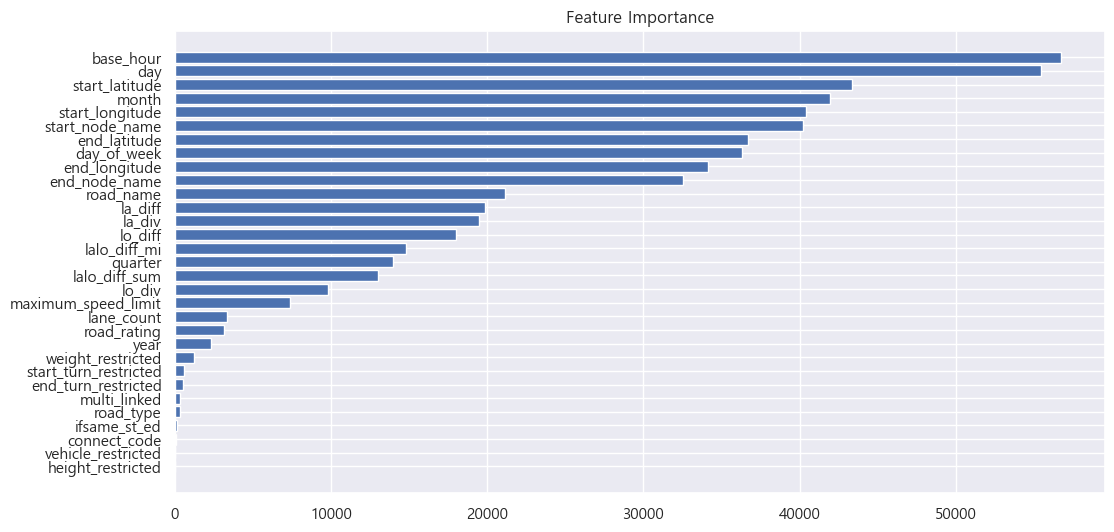

In [133]:
feature_importance = lgbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')

## Submission

In [134]:
import joblib

#joblib.dump(lgbm, '/content/drive/MyDrive/MYJ/open/lgbm_tune_model3.pkl')
joblib.dump(lgbm, 'lgbm_tune_model1103.pkl')
#lgbm = joblib.load('lgbm_tune_model1031.pkl')

['lgbm_tune_model1103.pkl']

In [135]:
lgbm_tune_submit_pred = lgbm.predict(test2)

y_pred2 = lgbm_tune_submit_pred
y_pred2 = pd.DataFrame(y_pred2)
y_pred2.columns = ['target']
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.drop('target', axis=1, inplace=True)
sub = pd.concat([sample_submission, y_pred2], axis=1)
print(sub.isnull().sum())
print(sub.head())
sub.to_csv("submitlgbm1103.csv", index = False)

id        0
target    0
dtype: int64
            id     target
0  TEST_000000  24.703936
1  TEST_000001  43.918702
2  TEST_000002  65.364437
3  TEST_000003  38.225969
4  TEST_000004  43.386948


In [136]:
# 오답 분석용
lgbm_train_submit_pred = lgbm.predict(x_final)

y_pred2 = lgbm_train_submit_pred
y_pred2 = pd.DataFrame(y_pred2)
y_pred2.columns = ['target']
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.drop('target', axis=1, inplace=True)
sub = pd.concat([sample_submission, y_pred2], axis=1)
print(sub.isnull().sum())
print(sub.head())
sub.to_csv("predictlgbm1103.csv", index = False)

id        4409976
target          0
dtype: int64
            id     target
0  TEST_000000  50.995526
1  TEST_000001  25.291747
2  TEST_000002  61.520971
3  TEST_000003  20.254997
4  TEST_000004  39.092213


### 랜덤포레스트

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(x_final, y)

In [ ]:
joblib.dump(rf, 'rf_train_model.pkl')

In [ ]:
rf_train_pred = rf.predict(x_final)

In [ ]:
mean_absolute_error(y, rf_train_pred)

In [ ]:
rftest = rf.predict(test2)

## Extratrees

In [137]:
from sklearn.ensemble import ExtraTreesRegressor

In [138]:
x_train, x_test, y_train, y_test = train_test_split(x_encoding, y_encoding, test_size=0.25, random_state=9)

In [139]:
er = ExtraTreesRegressor()

In [140]:
er.fit(x_train, y_train)

ExtraTreesRegressor()

In [141]:
erpredict = er.predict(x_test)
mean_absolute_error(y_test, erpredict)

3.8299104